In [96]:
import geopandas as gpd
import pandas as pd
from shapely import Point, Polygon
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pyproj
from osgeo import gdal
import numpy as np
import rioxarray as rxr
from shapely import box
from shapely.geometry import Point, MultiPolygon
import whitebox
import rasterio as rio
from rasterio.plot import show,show_hist
from rasterio.merge import merge
from rasterio.enums import Resampling, MergeAlg
from rasterio import features
wbt = whitebox.WhiteboxTools()
from osgeo import gdal
from numpy import int16, int32
import os, sys

In [97]:
def reproject_raster(input_fpath, out_fpath, crs):
    """Function to reproject raster"""
    # Open the raster using rioxarray
    raster = rxr.open_rasterio(input_fpath)
    # Reproject the raster
    reprojected_raster = raster.rio.reproject(crs)
    # Save the reprojected raster to a new file
    reprojected_raster.rio.to_raster(out_fpath)
    return out_fpath

In [98]:
def create_cummulative_viewshed(input_dem, input_shapefile, output_viewshed, blade_end_height):
    # Whitebox viewshed uses a clip DEM raster, TX AoI Wind Turbine shapefile and creates a "Viewshed Raster" as an output
    wbt.viewshed(input_dem, input_shapefile, output_viewshed, height=blade_end_height)

In [99]:
# Convert buffer units from mile to meter
def mile2meter(mile):
    """Function to convert and return buffer units from miles to meters"""
    return (1609.34*mile)
# Displays a plot with default colors
def visualize_wind_turbines_buffers(dataframe, title = "Wind Turbine locations with Buffer (EPSG:3857)"):
    """Function to visualize default buffer sizes with turbine point locations"""
    # Reads and reprojects wind turbine GeoDataFrame to EPSG:3857
    gdf_aoi = dataframe.to_crs(3857)
    # Create buffers for each point of sizes - 0.5, 4, 10 miles
    gdf_aoi_buffer_half_mile = gdf_aoi.geometry.buffer(mile2meter(0.5))
    gdf_aoi_buffer_four_mile = gdf_aoi.geometry.buffer(mile2meter(4))
    gdf_aoi_buffer_ten_mile = gdf_aoi.geometry.buffer(mile2meter(10))
    # Merge buffers into a single polygon and geometry is stored
    geom_half_mile = gdf_aoi_buffer_half_mile.geometry.unary_union
    geom_four_mile = gdf_aoi_buffer_four_mile.geometry.unary_union
    geom_ten_mile = gdf_aoi_buffer_ten_mile.geometry.unary_union
    # Each geometry is loaded as a GeoDataFrame
    s0 = gpd.GeoDataFrame(geometry=[geom_half_mile])
    s1 = gpd.GeoDataFrame(geometry=[geom_four_mile])
    s2 = gpd.GeoDataFrame(geometry=[geom_ten_mile])
    sp = gdf_aoi.geometry
    # Create a subplot and plot all geometries onto same plot
    fig, ax = plt.subplots(figsize=(10, 5))
    # Face colors are from Colorbrewer.org 
    s2.plot(ax=ax, facecolor='#e0ecf4', label='1')
    s1.plot(ax=ax, facecolor='#9ebcda')
    s0.plot(ax=ax, facecolor='#8856a7')
    sp.plot(ax=ax, color='#f0f0f0', marker="+", label="Wind Turbine")
    # Create custom legend handles
    legend_handles = [
        mpatches.Patch(color='#e0ecf4',  label="10 mile"),
        mpatches.Patch(color='#9ebcda', label="4 mile"),
        mpatches.Patch(color='#8856a7', label="0.5 mile")
    ]
    # Add a legend to the plot with custom handles
    ax.legend(handles=legend_handles)
    plt.title(title)
    plt.xlabel('Longitude (meter)')
    plt.ylabel('Latitude (meter)')
    plt.show()

In [100]:
# Creates a plot for viewshed with legend
def visualize_viewshed_windturbines(viewshed_fpath, dataframe, cmap="gist_yarg", title="Viewshed for Wind Turbine locations"):
    """Function to create visualization of viewshed with legend"""
    viewshed = rio.open(viewshed_fpath)
    fig, ax = plt.subplots(figsize=(10,5))
    image_hidden = ax.imshow(viewshed.read()[0], cmap=cmap)
    fig.colorbar(image_hidden, ax=ax, cmap=cmap)
    df = dataframe.to_crs(viewshed.crs.to_epsg())
    df.plot(ax=ax, marker="+", color="gray")
    show(viewshed, ax=ax, cmap=cmap)
    ax.set_title(f"{title} (EPSG:{viewshed.crs.to_epsg()})")
    plt.xlabel(f'Longitude ({viewshed.crs.units_factor[0]})')
    plt.ylabel(f'Latitude ({viewshed.crs.units_factor[0]})')
    plt.show()

In [101]:
# Creates a plot for viewshed with legend
def visualize_viewshed(viewshed_fpath, cmap="gist_yarg", title="Viewshed for a Wind Turbine location"):
    """Function to create visualization of viewshed with legend"""
    viewshed = rio.open(viewshed_fpath)
    fig, ax = plt.subplots(figsize=(10,5))
    image_hidden = ax.imshow(viewshed.read()[0], cmap=cmap)
    fig.colorbar(image_hidden, ax=ax, cmap=cmap)
    show(viewshed, ax=ax, cmap=cmap)
    ax.set_title(f"{title} (EPSG:{viewshed.crs.to_epsg()})")
    plt.xlabel(f'Longitude ({viewshed.crs.units_factor[0]})')
    plt.ylabel(f'Latitude ({viewshed.crs.units_factor[0]})')
    plt.show()

In [102]:
def visualize_dem(dem_fpath, cmap="gist_earth", title="Digital Elevation Model"):
    dst = rio.open(dem_fpath)
    fig, ax = plt.subplots(figsize=(10,5))
    image_hidden = ax.imshow(dst.read()[0], cmap=cmap)
    fig.colorbar(image_hidden, ax=ax, cmap=cmap)
    show(dst,ax=ax, cmap=cmap)
    ax.set_title(f'{title} (EPSG:{dst.crs.to_epsg()})')
    plt.xlabel(f'Longitude ({dst.crs.units_factor[0]})')
    plt.ylabel(f'Latitude ({dst.crs.units_factor[0]})')
    plt.show()

In [103]:
def visualize_wind_turbines(dataframe, title="Wind Turbine locations"):
    dataframe.plot(marker="+")
    plt.title(title)
    plt.xlabel('Longitude (meter)')
    plt.ylabel('Latitude (meter)')
    plt.show()

In [104]:
def create_relative_viewsheds(locations_shapefile, input_viewshed, output_dir, height, rl_type):
    gdf = gpd.read_file(locations_shapefile)
    input_viewshed = input_viewshed
    output_dir = output_dir
    height = height
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    # Create a relative viewshed for each point
    for idx, row in enumerate(gdf.itertuples(), start=1):
        x = row.geometry.x
        y = row.geometry.y
        # Create a unique output filename for each point with an index
        output_filename = os.path.join(output_dir, f'viewshed_{idx}_{rl_type}.tif')
        # Run gdal_viewshed for each point
        command = f'gdal_viewshed -md {height} -ox {x} -oy {y} {input_viewshed} {output_filename}'
        os.system(command)
        print(f'Viewshed created for point ({x}, {y}) and saved as {output_filename}')

    # Close the input and output datasets
    input_ds = None
    point_ds = None

In [105]:
def create_relative_viewsheds(locations_shapefile, input_viewshed, output_dir, height, rl_type):
    gdf = gpd.read_file(locations_shapefile)
    input_viewshed = input_viewshed
    output_dir = output_dir
    height = height
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    # Create a relative viewshed for each point
    for idx, row in enumerate(gdf.itertuples(), start=1):
        x = row.geometry.x
        y = row.geometry.y
        # Create a unique output filename for each point with an index
        output_filename = os.path.join(output_dir, f'viewshed_{idx}_{rl_type}.tif')
        # Run gdal_viewshed for each point
        command = f'gdal_viewshed -oz {height} -ox {x} -oy {y} {input_viewshed} {output_filename}'
        os.system(command)
        print(f'Viewshed created for point ({x}, {y}) and saved as {output_filename}')

    # Close the input and output datasets
    input_ds = None
    point_ds = None

In [106]:
def reclass_raster(viewshed_folder_path, original_value, new_value):
    for file in os.listdir(viewshed_folder_path):
        input_raster = os.path.join(viewshed_folder_path, file)
        # Value to reclassify
        original_value = original_value
        new_value = new_value
        # Open the input raster
        if input_raster.endswith('.tif'):
            with rio.open(input_raster) as src:
                # Read the raster data
                data = src.read(1)
                # Reclassify the data
                reclassified_data = np.where(data == original_value, new_value, data)
                # Update the data type to ensure it matches the output
                reclassified_data = reclassified_data.astype(src.profile['dtype'])
                # Copy the metadata from the source raster
                profile = src.profile
                output_raster = file.replace('.tif','_rc.tif')
                output_path = os.path.join(viewshed_folder_path, output_raster)
                # Write the reclassified data to the output raster
                with rio.open(output_path, 'w', **profile) as dst:
                    dst.write(reclassified_data, 1)
            print(f"Reclassification complete. Output saved as {output_path}")
        else:
            pass

In [107]:
# Function to merge reclassified rasters
def merge_rasters(input_paths, output_path):
    # Open each input raster
    src_files_to_mosaic = [rio.open(path) for path in input_paths]
    # Merge rasters
    merged_data, merged_transform = merge(src_files_to_mosaic, method='max', resampling=Resampling.nearest)
    # Update metadata for the output raster
    out_meta = src_files_to_mosaic[0].meta.copy()
    out_meta.update({"driver": "GTiff", 
                     "height": merged_data.shape[1], 
                     "width": merged_data.shape[2], 
                     "transform": merged_transform})
    # Write the merged raster to the output file
    with rio.open(output_path, "w", **out_meta) as dest:
        dest.write(merged_data)
    src_files_to_mosaic = []
    print(f"Mosaic created at {output_path}")

In [108]:
def unique_value(input_fpath):
    with rio.open(input_fpath) as dst:
        data = dst.read()
        print(np.unique(data))

In [109]:
def create_concentric_buffers(center_point, radii):
    buffers = [center_point.buffer(r) for r in radii]
    buffer0 = buffers[0]
    buffer1 = buffers[1].difference(buffers[0])
    buffer2 = buffers[2].difference(buffers[1])
    buffer3 = buffers[3].difference(buffers[2])
    ring_buffers = [buffer0, buffer1, buffer2, buffer3]
    return MultiPolygon(ring_buffers)

def kilo2meter(km):
    return km*1000

def rasterize_concentric_buffers(reference_raster, buffers, buffer_values_list, output_raster_path):
    raster = rio.open(reference_raster)
    vector_ids = buffer_values_list
    geom_value = ((geom,value) for geom, value in zip(buffers.geoms, vector_ids))
    # Rasterize vector using the shape and coordinate system of the raster
    rasterized = features.rasterize(geom_value,
                                    out_shape = raster.shape,
                                    transform = raster.transform,
                                    all_touched = False,
                                    fill = 0,   # background value
                                    merge_alg = MergeAlg.replace,
                                    dtype = int16)
    with rio.open(output_raster_path, "w", driver = "GTiff", crs = raster.crs, transform = raster.transform,
        dtype = rasterio.uint8,
        count = 1,
        width = raster.width,
        height = raster.height) as dst:
        dst.write(rasterized, indexes = 1)
    raster = None

In [110]:
def create_turbine_multiringbuffer_raster(locations_shapefile, reference_raster, output_folder_path):
    raster_flist = []
    gdf = gpd.read_file(locations_shapefile)
    gdf = gdf.to_crs(3857)
    for index, row in enumerate(gdf.itertuples()):
        point_geom = row.geometry
        radii = [kilo2meter(0.8), kilo2meter(3.2), kilo2meter(8), kilo2meter(16.1)]
        buffers = create_concentric_buffers(point_geom, radii)
        output_raster_path = os.path.join(output_folder_path, f'rasterized_{index+1}_turbine_buffer.tif')
        buffer_values_list = [1,2,3,4]
        rasterize_concentric_buffers(reference_raster, buffers, buffer_values_list, output_raster_path)
        raster_flist.append(output_raster_path)
        point_geom = None
        buffers = None
    return raster_flist

In [111]:
def create_turbine_viz_prominence(input_paths, output_path):
    files = [rxr.open_rasterio(path) for path in input_paths]
    raster_sum = files[0] + files[1]
    raster_sum.rio.to_raster(output_path)

In [112]:
def reclass_vizexp(vizexp_fpath):
    for file in os.listdir(vizexp_fpath):
        input_raster = os.path.join(vizexp_fpath, file)
        # Open the input raster
        if input_raster.endswith('.tif'):
            with rio.open(input_raster) as src:
                # Read the raster data
                data = src.read(1)
                rc = data.copy()

                # Reclassify the data
                reclass_dict = {
                    0: [0, 1, 2, 3, 4, 10, 14, 20, 30],
                    4: [11, 22, 33],
                    2: [12, 23, 34],
                    1: [13, 24],
                    7: [21],
                    6: [32],
                    10: [31]
                }

                for output_value, input_values in reclass_dict.items():
                    rc[np.isin(rc, input_values)] = output_value

                output_raster = file.replace('.tif', '_rc.tif')
                output_path = os.path.join(vizexp_fpath, output_raster)

                # Write the reclassified data to the output raster
                with rio.open(output_path, 'w', driver=src.driver, height=src.height, width=src.width,
                             count=src.count, crs=src.crs, transform=src.transform, dtype=data.dtype) as dst:
                    dst.write(rc, 1)

                print(f"Reclassification complete. Output saved as {output_path}")
        else:
            pass

In [113]:
def reclass_meaningful_visibility(vizexp_fpath):
    for file in os.listdir(vizexp_fpath):
        input_raster = os.path.join(vizexp_fpath, file)
        # Open the input raster
        if 'rc' not in input_raster:
            with rio.open(input_raster) as src:
                # Read the raster data
                data = src.read(1)
                rc = data.copy()

                # Reclassify the data
                reclass_dict = {
                    0: [0, 1, 2, 3, 4, 10, 14, 20, 30],
                    1: [11, 12, 13, 21, 22, 23, 24, 31, 32, 33, 34]
                }

                for output_value, input_values in reclass_dict.items():
                    rc[np.isin(rc, input_values)] = output_value

                output_raster = file.replace('vizexp.tif', 'mv_rc.tif')
                output_path = os.path.join(vizexp_fpath, output_raster)

                # Write the reclassified data to the output raster
                with rio.open(output_path, 'w', driver=src.driver, height=src.height, width=src.width,
                             count=src.count, crs=src.crs, transform=src.transform, dtype=data.dtype) as dst:
                    dst.write(rc, 1)

                print(f"Reclassification complete. Output saved as {output_path}")
        else:
            pass

In [114]:
def calc_cummulative_visualprominence(input_paths, output_path):
    # Initialize raster_sum
    raster_sum = None
    # Open each raster file and accumulate values
    for file in input_paths:
        raster = rxr.open_rasterio(file)
        if raster_sum is None:
            raster_sum = raster
        else:
            raster_sum += raster

    # Write the cumulative raster to the output path
    raster_sum.rio.to_raster(output_path)
    
    print('Created cumulative viz prominence')

In [115]:
def calc_mean_prominence(vizexp_fpath, mv_fpath, output_path):
    with rio.open(vizexp_fpath) as src1, rio.open(mv_fpath) as src2:
        # Read the raster data
        data1 = src1.read(1)
        data2 = src2.read(1)

        # Avoid division by zero
        data2_nonzero = data2.copy()
        data2_nonzero[data2 == 0] = 1

        # Perform the division
        result = np.where(data2 == 0, np.nan, data1 / data2_nonzero)

        # Write the result to the output raster
        profile = src1.profile
        profile.update(dtype='float32', count=1)

        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(result, 1)

In [116]:
gdf_tx_aoi = gpd.read_file(r"datasets/tx_aoi.shp")
gdf_tx_aoi = gdf_tx_aoi.to_crs(3857)

In [137]:
len(gdf_tx_aoi)

42

<Axes: >

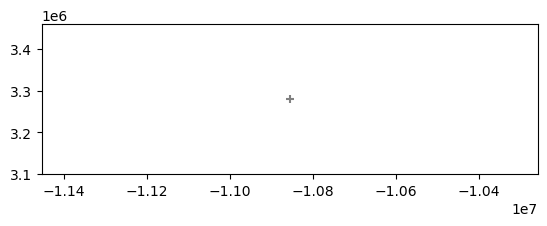

In [117]:
gdf_tx_aoi.iloc[1:2].plot(marker="+", color="gray")

In [118]:
def visualize_viewshed_windturbine(fpath,viewshed_fpath, turbine_index, cmap="gist_yarg", title="Viewshed for Wind Turbine"):
    """Function to create visualization of viewshed with legend"""
    try:
        viewshed = rio.open(viewshed_fpath)
        fig, ax = plt.subplots(figsize=(10,5))
        image_hidden = ax.imshow(viewshed.read()[0], cmap=cmap)
        fig.colorbar(image_hidden, ax=ax, cmap=cmap)
        gdf = gpd.read_file(fpath)
        gdf = gdf.to_crs(3857)
        gdf.iloc[turbine_index-1:turbine_index].plot(ax=ax, marker="1", color="#31a354", markersize=1000)
        show(viewshed, ax=ax, cmap=cmap)
        ax.set_title(f"{title} {turbine_index} (EPSG:{viewshed.crs.to_epsg()})")
        plt.xlabel(f'Longitude ({viewshed.crs.units_factor[0]})')
        plt.ylabel(f'Latitude ({viewshed.crs.units_factor[0]})')
        plt.show()
        viewshed = None
    except TypeError as e:
        print("Wrong type assigned to turbine index, it has to be an integer and within index range")
    except turbine_index not in range(0, len(gdf)):
        print(f"Turbine index is out range, please enter a range between (0:{len(gdf)})")

Enter a value to check merged viewshed:33


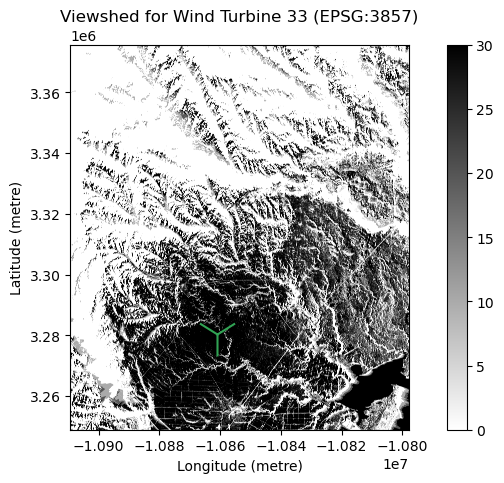

In [150]:
input_value = int(input("Enter a value to check merged viewshed:"))
visualize_viewshed_windturbine("datasets/tx_aoi.shp",
                              f"viewsheds_merged/merged_{input_value}_viewshed_reproj.tif",
                              input_value)

In [147]:
def visualize_viewshed_windturbine(fpath, viewshed_fpath, turbine_index, cmap="gist_yarg", title="Viewshed for Wind Turbine"):
    """Function to create visualization of viewshed with legend"""
    try:
        # Open the viewshed raster
        viewshed = rio.open(viewshed_fpath)
        # Read the turbine locations GeoDataFrame
        gdf = gpd.read_file(fpath)
        gdf = gdf.to_crs(3857)
        if type(turbine_index) != int:
            raise TypeError
        if turbine_index not in range(1, len(gdf)+1):
            raise ValueError
        # Plot the viewshed
        fig, ax = plt.subplots(figsize=(10, 5))
        image_hidden = ax.imshow(viewshed.read()[0], cmap=cmap)
        fig.colorbar(image_hidden, ax=ax, cmap=cmap)
        # Plot the turbine location
        gdf.iloc[turbine_index-1:turbine_index].plot(ax=ax, marker="1", color="#31a354", markersize=1000)
        # Show the plot
        show(viewshed, ax=ax, cmap=cmap)
        # Set plot title and labels
        ax.set_title(f"{title} {turbine_index} (EPSG:{viewshed.crs.to_epsg()})")
        plt.xlabel(f'Longitude ({viewshed.crs.units_factor[0]})')
        plt.ylabel(f'Latitude ({viewshed.crs.units_factor[0]})')
        plt.show()
    except TypeError:
        print(f"TypeError: Turbine index has to be an integer.")
    except ValueError:
        print(f"Turbine index has to be in range (1,{len(gdf)})")
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")
    finally:
        if "viewshed" in locals() and viewshed is not None:
            viewshed.close()